[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/11au9s4Hox89d0zcU1GjwuAERdEteoFxJ?usp=sharing)

Source: https://github.com/ezponda/intro_deep_learning/blob/main/class/RNN/IMBD_RNN.ipynb

# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

tf.keras.utils.set_random_seed(0)


def show_loss_accuracy_evolution(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The  parameter `num_words` controls how many words different we want to use.

In [ ]:
from tensorflow.keras.datasets import imdb
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

17464789/17464789 [==============================] - 0s 0us/step
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178,

In [ ]:
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

1641221/1641221 [==============================] - 0s 0us/step


For transforming an id-sequence to a phrase use get_words

In [ ]:
def get_words(sentence, int2word):
    return ' '.join([int2word.get(i, '<UNK>') for i in sentence])


get_words(train_data[0], int2word)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# MLP model

## Data Preprocessing

You need to convert your raw text to an appropriate input to a sequential model

In [ ]:
def vectorize_text_sentence(text, word2int):
    tokens = text.split(' ')
    tokens_id = [word2int.get(tk,2) for tk in tokens]
    return tokens_id

text = get_words(train_data[0], int2word)
print(text)
print(vectorize_text_sentence(text, word2int))

We are going to use a bag of words model. BoW is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the Each key is the word, and each value is the frequency of occurrences of that word in the given text document.

- **Input document**: `"John likes to watch movies Mary likes movies too"`
- **BoW**: `{'John': 0.11, 'likes': 0.22, 'to': 0.11, 'watch': 0.11, 'movies': 0.22, 'Mary': 0.11, 'too': 0.11}`


In [ ]:
from collections import Counter


def get_bag_of_words(sequence, norm=True):
    word_count = Counter(sequence)
    if norm:
        total = sum(word_count.values())
        word_freq = {w: n / total for w, n in word_count.items()}
        return word_freq
    else:
        return dict(word_count.items())


text_example = "John likes to watch movies Mary likes movies too"
print('text_example', text_example)
text_sequence = text_example.split()
print('text splitted', text_sequence)
bag_of_words = get_bag_of_words(text_sequence)
print('bag_of_words', bag_of_words)
print('bag_of_words norm=False', get_bag_of_words(text_sequence, norm=False))
print(
    'bag_of_words with indexes', {
        word2int[w.lower()]: p
        for w, p in get_bag_of_words(text_sequence, norm=False).items()
    })

text_example John likes to watch movies Mary likes movies too
text splitted ['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too']
bag_of_words {'John': 0.1111111111111111, 'likes': 0.2222222222222222, 'to': 0.1111111111111111, 'watch': 0.1111111111111111, 'movies': 0.2222222222222222, 'Mary': 0.1111111111111111, 'too': 0.1111111111111111}
bag_of_words norm=False {'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}
bag_of_words with indexes {308: 1, 1232: 2, 8: 1, 106: 1, 102: 2, 1083: 1, 99: 1}


After that, we convert every BoW to a vector of `dim=num_words` with `vectorize_sequences`

In [ ]:
def vectorize_sequence(sequence, num_words, norm=True):
    vec = np.zeros(num_words)
    bow = get_bag_of_words(sequence, norm)
    for w, freq in bow.items():
        if w < num_words:
            vec[w] = freq
    return vec


def vectorize_sequences(sequences, num_words=num_words, norm=True):
    """Creates an all-zero matrix of shape (len(sequences), num_words)"""
    results = np.zeros((len(sequences), num_words))
    for i, sequence in enumerate(sequences):
        results[i, :] = vectorize_sequence(sequence, num_words, norm)
    return results


x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

In [ ]:
x_train[0]

array([0.        , 0.00458716, 0.02752294, ..., 0.        , 0.        ,
       0.        ])

## Define and train a model
Define, compile and fit your sequential model

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(10, input_shape=(10003, ), activation='sigmoid'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │         100,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,161 (391.25 KB)

 Trainable params: 100,161 (391.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, validation_split=0.2)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5071 - loss: 0.6997 - val_accuracy: 0.6170 - val_loss: 0.6922
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5148 - loss: 0.6974 - val_accuracy: 0.7732 - val_loss: 0.6907
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5272 - loss: 0.6946 - val_accuracy: 0.7730 - val_loss: 0.6872
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5503 - loss: 0.6887 - val_accuracy: 0.7742 - val_loss: 0.6790
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5811 - loss: 0.6798 - val_accuracy: 0.7788 - val_loss: 0.6609
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6229 - loss: 0.6618 - val_accuracy: 0.7870 - val_loss: 0.6241
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6601 - loss: 0.6295 - val_accuracy: 0.7962 - val_loss: 0.5736
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6914 - loss: 0.5905 - val_accuracy: 0

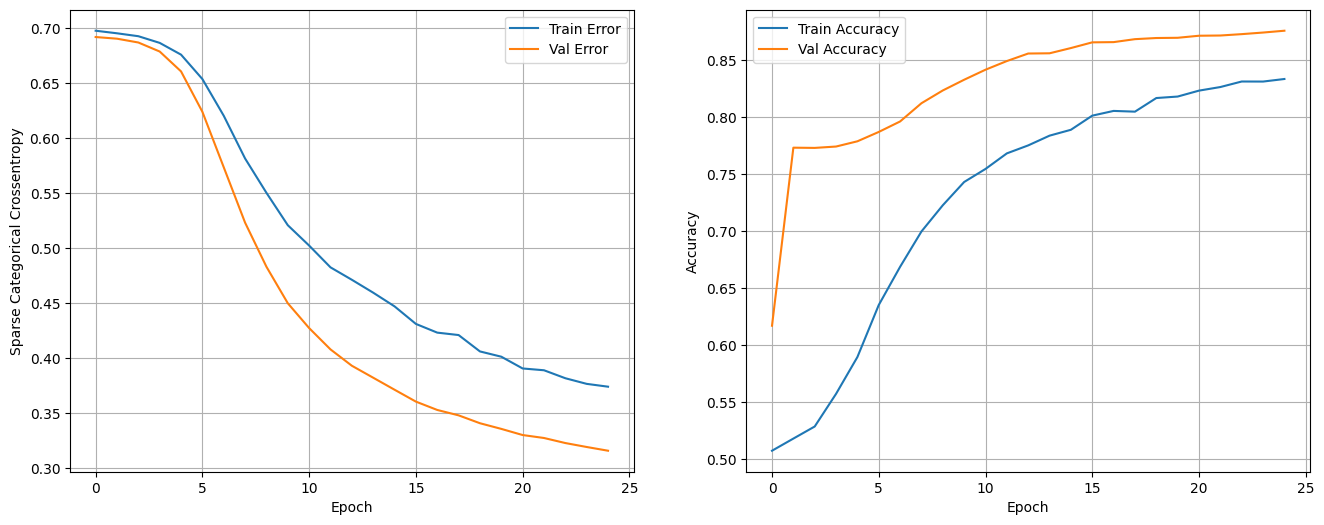

In [ ]:
show_loss_accuracy_evolution(history)

### Evaluate the model
You need to obtain a Test Accuracy > 0.85. Try to get more than 0.9!

In [ ]:
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8709 - loss: 0.3238
Test Loss: 0.3241058886051178
Test Accuracy: 0.8708000183105469


### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant']

sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

x_pred = vectorize_sequences(sequences, num_words=num_words)
np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


array([[0.0172],
       [0.9981],
       [0.3659]], dtype=float32)

# RNN model

Lets use a recurrent neural network and compare results


### Simple RNN model

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In sequence classification we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [5]:
# dims of input: [batch, tokens, embedding_dim]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, tokens, embedding_dim): ', inputs.shape)
lstm = tf.keras.layers.LSTM(units=2)
output = lstm(inputs)
print('1. return_state=False output shape: ',output.shape)
lstm = tf.keras.layers.LSTM(units=2, return_sequences=True)
output = lstm(inputs)
print('2. return_state=True output shape: ',output.shape)

input dim (batch, timesteps, feature):  (32, 10, 4)
1. return_state=False output shape:  (32, 2)
2. return_state=True output shape:  (32, 10, 2)


### Loading Data

In [ ]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
'''size = 15000
(train_data, train_labels), (test_data, test_labels) = (
    (train_data[:size], train_labels[:size]), (test_data[:size], test_labels[:size]))
'''
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

print(train_data.shape, test_data.shape)

(25000,) (25000,)


### Create the RNN model

For the input of the first rnn layer we need a tensor of `(timesteps, features)` or `(batchsize, timesteps, features)`. We have a matrix of sentences of `(train_size, max_len)`. Every sentence is a  `max_len`, we need to convert it to a sentence of one-hot vectors of dim `(max_len, num_words)`.
For get the one-hot encoding of every sequence we are going to use:

```python
layers.Embedding(input_dim=num_words, output_dim=num_words,
  input_length=max_len, embeddings_initializer='identity', trainable=False)
```

This layer converts the input tensor `(batch_size, max_len)` to one-hot encoded sequences `(batch_size, max_len, num_words)`





In [ ]:
max_len = 100
x_train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


In [ ]:
seq = np.array([[[0, 1, 2, 2, 0]]])
print(seq, seq.shape)
layers.Embedding(input_dim=3, output_dim=3,
                 input_length=5, embeddings_initializer='identity',
                 trainable=False)(seq)

[[[0 1 2 2 0]]] (1, 1, 5)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<tf.Tensor: shape=(1, 1, 5, 3), dtype=float32, numpy=
array([[[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]]], dtype=float32)>

### RNN model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` or `keras.layers.Bidirectional`


In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))
## complete the model with recurrent layers
model.add(layers.SimpleRNN(16, return_sequences=False))

## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 2000)         4000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                32272     
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 4032289 (15.38 MB)
Trainable params: 32289 (126.13 KB)
Non-trainable params: 4000000 (15.26 MB)
_________________________________________________________________


In [ ]:
## set the loss and see the results
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)


Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.5143 - loss: 0.6944 - val_accuracy: 0.6424 - val_loss: 0.6595
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6926 - loss: 0.6142 - val_accuracy: 0.7720 - val_loss: 0.5207
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7913 - loss: 0.4787 - val_accuracy: 0.7888 - val_loss: 0.4833
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8276 - loss: 0.4117 - val_accuracy: 0.7984 - val_loss: 0.4469
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8450 - loss: 0.3801 - val_accuracy: 0.7880 - val_loss: 0.4682


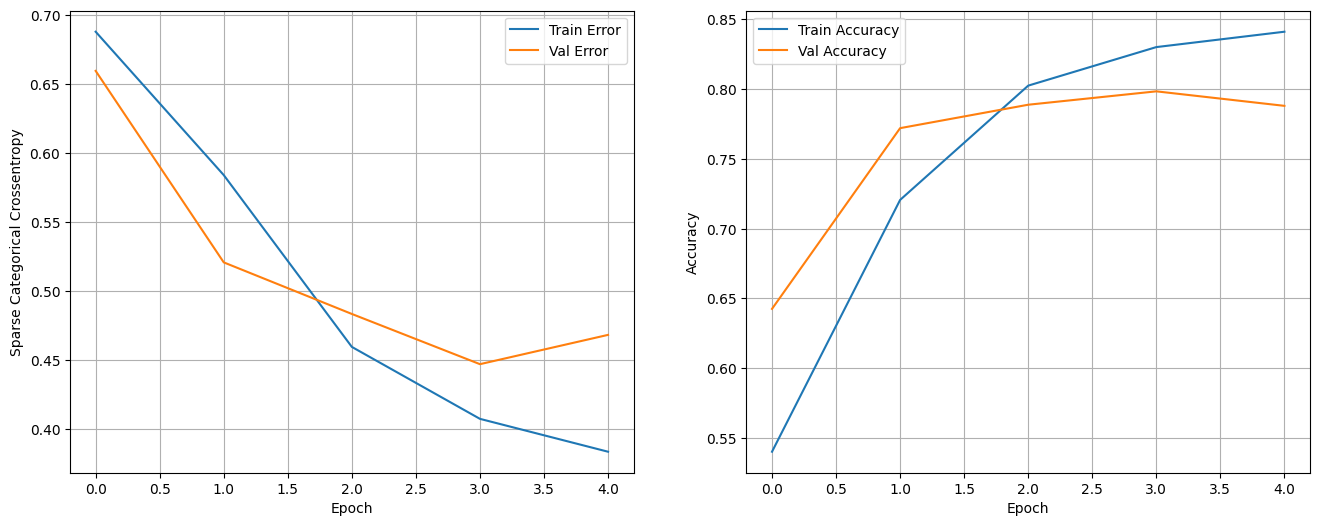

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7868 - loss: 0.4727
Test Loss: 0.471746563911438
Test Accuracy: 0.7876399755477905


In [ ]:
show_loss_accuracy_evolution(history)
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [ ]:
def show_errors(x_test, model, labels, int2word, n_samples=10):
    preds = 1.0 * (model.predict(x_test).flatten() > 0.5)
    bad_pred_inds = np.where(preds != labels)[0]
    n_samples = min(len(bad_pred_inds), n_samples)
    samples_inds = np.random.choice(bad_pred_inds, n_samples)
    for ind in samples_inds:
        print('Predicted : {0}, real : {1}, lenght: {2}'.format(
            int(preds[ind]), labels[ind], len(test_data[ind])))
        print(get_words(test_data[ind], int2word))
        print()
    return

show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Predicted : 0, real : 1, lenght: 213
<START> <UNK> director david <UNK> <UNK> love of blood and gore and <UNK> heads with the more confusing aspects of a reality <UNK> david <UNK> film and it actually works <UNK> i won't bother trying to give even the <UNK> <UNK> of a plot <UNK> here because <UNK> only cause more <UNK> all you need to know is that the film is about a <UNK> reality computer game that is so incredibly <UNK> that it becomes difficult to tell the difference between reality and <UNK> reality the film almost seems to <UNK> its <UNK> <UNK> point at the end but then it <UNK> in the final twist in the very last line of dialogue br br there's also some very <UNK> sexual <UNK> based around the in the <UNK> <UNK> as well as some very <UNK> acting from <UNK> law he manages to come off as <UNK> and stupid and boring and any other annoying <UNK> you can care to think of jason <UNK> <UNK> comes off much better and everyone else can be called a 

#### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


array([[0.0867],
       [0.9273],
       [0.9272],
       [0.9271],
       [0.0869],
       [0.0879]], dtype=float32)

In [ ]:
1.0*(model.predict(x_pred) > 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]])

### GRU model
Use `keras.layers.GRU`


In [16]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.GRU(16, return_sequences=True))
model.add(layers.GRU(16, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 2000)         4000000   
                                                                 
 gru_4 (GRU)                 (None, 100, 16)           96864     
                                                                 
 gru_5 (GRU)                 (None, 16)                1632      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4098513 (15.63 MB)
Trainable params: 98513 (384.82 KB)
Non-trainable params: 4000000 (15.26 MB)
_________________________________________________________________


In [ ]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5099 - loss: 0.6929 - val_accuracy: 0.5676 - val_loss: 0.6857
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6375 - loss: 0.6358 - val_accuracy: 0.7832 - val_loss: 0.4782
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8008 - loss: 0.4478 - val_accuracy: 0.8076 - val_loss: 0.4206
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8282 - loss: 0.3897 - val_accuracy: 0.8124 - val_loss: 0.4090
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8412 - loss: 0.3686 - val_accuracy: 0.8168 - val_loss: 0.4084


In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8087 - loss: 0.4186
Test Loss: 0.4201999604701996
Test Accuracy: 0.8063600063323975


### LSTM model
Use `keras.layers.LSTM`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.LSTM(16, return_sequences=True))
model.add(layers.LSTM(16, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5390 - loss: 0.6821 - val_accuracy: 0.7544 - val_loss: 0.5232
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7843 - loss: 0.4787 - val_accuracy: 0.8012 - val_loss: 0.4494
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8341 - loss: 0.3885 - val_accuracy: 0.8116 - val_loss: 0.4288
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8506 - loss: 0.3602 - val_accuracy: 0.8140 - val_loss: 0.4240
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8545 - loss: 0.3504 - val_accuracy: 0.8156 - val_loss: 0.4068


In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8098 - loss: 0.4165
Test Loss: 0.4194280207157135
Test Accuracy: 0.8042399883270264


### Bidirectional model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` with `keras.layers.Bidirectional`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=True))

## complete the model with recurrent layers
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=False)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## set the loss and see the results
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

epochs = 50
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.15, epochs=epochs,
                    batch_size=128, callbacks=[es_callback])

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.5371 - loss: 0.6919 - val_accuracy: 0.6184 - val_loss: 0.6850
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.6351 - loss: 0.6738 - val_accuracy: 0.7272 - val_loss: 0.5852
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.7637 - loss: 0.5291 - val_accuracy: 0.7901 - val_loss: 0.4643
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8132 - loss: 0.4280 - val_accuracy: 0.7984 - val_loss: 0.4445
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8303 - loss: 0.3966 - val_accuracy: 0.8059 - val_loss: 0.4361
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8396 - loss: 0.3800 - val_accuracy: 0.8067 - val_loss: 0.4334
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8448 - loss: 0.3708 - val_accuracy: 0.8080 - val_loss: 0.4293
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8505 - loss: 0.3625 - val_a

In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8067 - loss: 0.4333
Test Loss: 0.4389667510986328
Test Accuracy: 0.8053200244903564


#### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


array([[0.4058],
       [0.9465],
       [0.6785],
       [0.5848],
       [0.4373],
       [0.4498]], dtype=float32)

In [ ]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
Predicted : 1, real : 0, lenght: 200
<START> i really wanted to like this film for all <UNK> of reasons the subject matter is <UNK> interesting and is probably the major issue <UNK> the world today and has thrown up fascinating works e g <UNK> <UNK> when i lived in modern times usually from the <UNK> side of the <UNK> also a <UNK> i like told me he thought it was the best film <UNK> seen all year so with such a <UNK> br br however i actually found myself <UNK> off at points <UNK> i was tired and the cinema <UNK> <UNK> but i found it too much hard work trying to <UNK> with the characters once i'd got my head <UNK> the idea that it was a series of <UNK> i went with it but this made it <UNK> like a <UNK> show rather than a film i liked the concept of a <UNK> almost silent <UNK> <UNK> scene <UNK> to these <UNK> moments the sexy girl the red <UNK> and the <UNK> <UNK> <UNK> but personally i think the film has been over <UNK> i'm not saying narrative a

###  Use a convolutional network instead of a RNN

```python
tf.keras.layers.Conv1D(
    filters, kernel_size
)
```

```python
tf.keras.layers.MaxPool1D(
    pool_size=2
)
```

```python
tf.keras.layers.Flatten()
```

In [ ]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3


In [ ]:
max_len = 100
x_train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))


model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.4965 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.6885
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6441 - loss: 0.6290 - val_accuracy: 0.7936 - val_loss: 0.4476
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8075 - loss: 0.4252 - val_accuracy: 0.8176 - val_loss: 0.4044
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8416 - loss: 0.3629 - val_accuracy: 0.8176 - val_loss: 0.3982
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8592 - loss: 0.3255 - val_accuracy: 0.8212 - val_loss: 0.4022
